# Importing Libraries

In [1]:
import os
import sys
import random
import cv2


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.transforms import functional as TF

from PIL import Image, ImageFilter
import numpy as np
from sklearn.metrics import f1_score
from segmentation_models_pytorch import Unet
import matplotlib.pyplot as plt

# Setting GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

C:\Users\MSII\anaconda3\envs\Deep_Learning_Course\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device

device(type='cuda')

# Creating the custom dataset

In [3]:
class RoadSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir=None, transform=None, is_test=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.is_test = is_test
        
        if is_test:
            # For test set, look for images in subdirectories
            self.images = []
            for test_dir in sorted(os.listdir(image_dir)):
                dir_path = os.path.join(image_dir, test_dir)
                if os.path.isdir(dir_path):
                    for img in os.listdir(dir_path):
                        if img.endswith(('.png', '.jpg', '.jpeg')):
                            self.images.append(os.path.join(test_dir, img))
        else:
            self.images = os.listdir(image_dir)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_path).convert('RGB')
        image = image.resize((416, 416))  
        
        if self.transform:
            image = self.transform(image)
            
        if self.is_test:
            return image, self.images[idx]  
        else:
            mask_path = os.path.join(self.mask_dir, self.images[idx])
            mask = Image.open(mask_path).convert('L')
            mask = mask.resize((416, 416))  
            mask = transforms.ToTensor()(mask)
            mask = (mask > 0.5).float()
            return image, mask

# Trial-1: Training on the original data
## Creating transformations, dataloaders

In [4]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

In [5]:
# Create training datasets
train_val_dataset = RoadSegmentationDataset(
    image_dir=r"C:\\Users\\MSII\\Desktop\\sanad_JU\\Materials\\Deep Learning\\Project\\training\\images",
    mask_dir=r"C:\\Users\\MSII\\Desktop\\sanad_JU\\Materials\\Deep Learning\\Project\\training\\groundtruth",
    transform=transform
)

# Create test dataset
test_dataset = RoadSegmentationDataset(
    image_dir=r"C:\\Users\\MSII\\Desktop\\sanad_JU\\Materials\\Deep Learning\\Project\\test_set_images",
    transform=transform,
    is_test=True
)

In [6]:
train_size = int(0.8 * len(train_val_dataset))  # 80% for training
val_size = len(train_val_dataset) - train_size  # 20% for validation

train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [train_size, val_size])

In [7]:
# Use all data for training the GAN (no split needed since we have separate test dataset)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Training samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 80
Training samples: 20
Test samples: 50


In [8]:
for image, mask in train_loader:
    print(image.shape, mask.shape)
    break

for image, mask in test_loader:
    print(image.shape)
    break

torch.Size([4, 3, 416, 416]) torch.Size([4, 1, 416, 416])
torch.Size([2, 3, 416, 416])


## Loading Unet model, and training on the dataset

In [9]:
# Initialize pre-trained UNet model
model = Unet(
    encoder_name="resnet34",      
    encoder_weights="imagenet",     
    in_channels=3,                 
    classes=1,                      
).to(device)

In [10]:
def train_model_and_f1_score(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    best_val_f1 = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_f1': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        batch_count = 0
        
        for batch_idx, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)
            
            # Ensure masks have correct shape
            if masks.dim() == 3:
                masks = masks.unsqueeze(1)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            batch_count += 1
            
        # Calculate average training loss
        avg_train_loss = train_loss / batch_count
            
        # Validation phase
        model.eval()
        val_f1 = 0
        val_loss = 0
        batch_count = 0
        all_preds = []
        all_masks = []
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                
                # Ensure masks have correct shape
                if masks.dim() == 3:
                    masks = masks.unsqueeze(1)
                
                outputs = model(images)
                val_loss += criterion(outputs, masks).item()
                
                pred = (torch.sigmoid(outputs) > 0.5).float()
                
                # Collect predictions and masks for F1 calculation
                all_preds.extend(pred.cpu().numpy().flatten())
                all_masks.extend(masks.cpu().numpy().flatten())
                
                batch_count += 1
        
        # Calculate metrics
        avg_val_loss = val_loss / batch_count
        val_f1 = f1_score(all_masks, all_preds)
        
        # Store history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_f1'].append(val_f1)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val F1: {val_f1:.4f}')
        
        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_f1': val_f1,
            }, 'C:\\Users\\MSII\\Desktop\\sanad_JU\\Materials\\Deep Learning\\Project\\model_original.pth')
            
    return best_val_f1, history

In [11]:
# Initialize loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the model
num_epochs = 15
val_f1, history = train_model_and_f1_score(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch [1/15] Train Loss: 0.6207, Val Loss: 0.5515, Val F1: 0.4102
Epoch [2/15] Train Loss: 0.5084, Val Loss: 0.4921, Val F1: 0.5819
Epoch [3/15] Train Loss: 0.3938, Val Loss: 0.3623, Val F1: 0.7081
Epoch [4/15] Train Loss: 0.3049, Val Loss: 0.3129, Val F1: 0.7570
Epoch [5/15] Train Loss: 0.2510, Val Loss: 0.2700, Val F1: 0.7832
Epoch [6/15] Train Loss: 0.2168, Val Loss: 0.2525, Val F1: 0.7914
Epoch [7/15] Train Loss: 0.1909, Val Loss: 0.2384, Val F1: 0.8086
Epoch [8/15] Train Loss: 0.1779, Val Loss: 0.2301, Val F1: 0.8107
Epoch [9/15] Train Loss: 0.1590, Val Loss: 0.2168, Val F1: 0.8256
Epoch [10/15] Train Loss: 0.1507, Val Loss: 0.2199, Val F1: 0.8139
Epoch [11/15] Train Loss: 0.1385, Val Loss: 0.2031, Val F1: 0.8226
Epoch [12/15] Train Loss: 0.1298, Val Loss: 0.2035, Val F1: 0.8177
Epoch [13/15] Train Loss: 0.1237, Val Loss: 0.1936, Val F1: 0.8304
Epoch [14/15] Train Loss: 0.1121, Val Loss: 0.2018, Val F1: 0.8278
Epoch [15/15] Train Loss: 0.1035, Val Loss: 0.1962, Val F1: 0.8253


## Testing and evaluating F1-score on the original dataset

In [12]:
def test_model_f1_scores(model, test_loader, output_dir='C:\\Users\\MSII\\Desktop\\sanad_JU\\Materials\\Deep Learning\\Project\\Predictions'):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    test_f1_scores = []
    
    with torch.no_grad():
        for images, image_names in test_loader:
            images = images.to(device)
            
            # Generate predictions
            outputs = model(images)
            predictions = (torch.sigmoid(outputs) > 0.5).float()
            
            # Calculate F1 score
            batch_f1 = f1_score(predictions.cpu().numpy().flatten(), 
                              outputs.cpu().numpy().flatten() > 0.5)
            test_f1_scores.append(batch_f1)
            
            # Save predictions
            for pred, name in zip(predictions, image_names):
                # Convert prediction to image
                pred_img = (pred.cpu().numpy()[0] * 255).astype(np.uint8)
                pred_img = Image.fromarray(pred_img)
                pred_img = pred_img.resize((400, 400))
                
                # Create directory and save
                test_num = name.split(os.sep)[0]
                os.makedirs(os.path.join(output_dir, test_num), exist_ok=True)
                save_path = os.path.join(output_dir, test_num, 'prediction.png')
                pred_img.save(save_path)
    
    print(f"Completed predictions for {len(test_loader.dataset)} test images")
    return test_f1_scores

In [13]:
checkpoint = torch.load('C:\\Users\\MSII\\Desktop\\sanad_JU\\Materials\\Deep Learning\\Project\\model_original.pth')

# Extract just the model state dict
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [14]:
f1_scores = test_model_f1_scores(model, test_loader,
                                 output_dir = 'C:\\Users\\MSII\\Desktop\\sanad_JU\\Materials\\Deep Learning\\Project\\Predictions_original_data')

Completed predictions for 50 test images


In [15]:
print(f'Min F1 Score: {min(f1_scores):.4f}')
print(f'Max F1 Score: {max(f1_scores):.4f}')

Min F1 Score: 0.9130
Max F1 Score: 0.9603


# Trial-2: Applying data augmentation using Pix2Pix model
- Since the training sample size is small, we will apply data augmentation to increase the sample size
- to provide more robustness for real world applications

In [27]:
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super().__init__()
        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super().__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        # Add size check 
        # If the spatial sizes of x and skip_input don’t match, resizes x to match skip_input
        if x.size(2) != skip_input.size(2) or x.size(3) != skip_input.size(3):
            x = F.interpolate(x, size=(skip_input.size(2), skip_input.size(3)))
        return torch.cat((x, skip_input), 1)

In [28]:
class Pix2PixGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.down1 = UNetDown(1, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512)
        self.down5 = UNetDown(512, 512)
        self.down6 = UNetDown(512, 512)
        
        # Decoder
        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 256, dropout=0.5)
        self.up4 = UNetUp(512, 128)
        self.up5 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, 3, 4, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)

        # Decoder
        u1 = self.up1(d6, d5)
        u2 = self.up2(u1, d4)
        u3 = self.up3(u2, d3)
        u4 = self.up4(u3, d2)
        u5 = self.up5(u4, d1)

        return self.final(u5)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        #  input channels 4 (3 for real/fake image + 1 for mask)
        self.model = nn.Sequential(
            nn.Conv2d(4, 64, 4, stride=2, padding=1),  
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, 4, padding=1)
            # Reducing the feature map depth to 1 channel, producing a single scalar output for each patch.
            # The discriminator evaluates each patch individually, as opposed to the entire image, making it a PatchGAN discriminator.
        )

    def forward(self, img_A, img_B):
        # img_A is the generated/real image (3 channels)
        # img_B is the mask (1 channel)
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [29]:
class RoadSegmentationGAN:
    def __init__(self):
        self.generator = Pix2PixGenerator().to(device)
        self.discriminator = Discriminator().to(device)
        self.criterion_GAN = nn.MSELoss()
        self.criterion_pixelwise = nn.L1Loss()
        self.lambda_pixel = 50  

    def train_gan(self, train_loader, num_epochs=3000):
        optimizer_G = torch.optim.Adam(self.generator.parameters(), lr=0.0001, betas=(0.5, 0.999))  
        optimizer_D = torch.optim.Adam(self.discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

        for epoch in range(num_epochs):
            epoch_d_loss = 0
            epoch_g_loss = 0
            num_batches = 0
            
            for i, (real_images, real_masks) in enumerate(train_loader):
                batch_size = real_images.size(0)
                real_images = real_images.to(device)
                real_masks = real_masks.to(device)

                if real_masks.dim() == 3:
                    real_masks = real_masks.unsqueeze(1)

                # Train Discriminator
                optimizer_D.zero_grad()
                fake_images = self.generator(real_masks)
                pred_fake = self.discriminator(fake_images.detach(), real_masks)
                loss_D_fake = self.criterion_GAN(pred_fake, torch.zeros_like(pred_fake))
                pred_real = self.discriminator(real_images, real_masks)
                loss_D_real = self.criterion_GAN(pred_real, torch.ones_like(pred_real))
                loss_D = (loss_D_fake + loss_D_real) * 0.5
                loss_D.backward()
                optimizer_D.step()

                # Train Generator
                optimizer_G.zero_grad()
                pred_fake = self.discriminator(fake_images, real_masks)
                loss_G_GAN = self.criterion_GAN(pred_fake, torch.ones_like(pred_fake))
                loss_G_L1 = self.criterion_pixelwise(fake_images, real_images) * self.lambda_pixel
                loss_G = loss_G_GAN + loss_G_L1
                loss_G.backward()
                optimizer_G.step()

                epoch_d_loss += loss_D.item()
                epoch_g_loss += loss_G.item()
                num_batches += 1

            # Print average losses only every 10 epochs
            if (epoch + 1) % 10 == 0:
                avg_d_loss = epoch_d_loss / num_batches
                avg_g_loss = epoch_g_loss / num_batches
                print(f"Epoch [{epoch+1}/{num_epochs}] D loss: {avg_d_loss:.4f} G loss: {avg_g_loss:.4f}")

In [12]:
# Usage
gan = RoadSegmentationGAN()
print("Training Pix2Pix GAN...")
gan.train_gan(train_loader)

Training Pix2Pix GAN...
Epoch [10/3000] D loss: 0.0410 G loss: 31.0965
Epoch [20/3000] D loss: 0.0192 G loss: 27.3773
Epoch [30/3000] D loss: 0.0168 G loss: 24.7084
Epoch [40/3000] D loss: 0.0097 G loss: 23.4588
Epoch [50/3000] D loss: 0.0081 G loss: 22.6674
Epoch [60/3000] D loss: 0.0097 G loss: 21.9619
Epoch [70/3000] D loss: 0.0053 G loss: 21.3995
Epoch [80/3000] D loss: 0.0073 G loss: 21.0367
Epoch [90/3000] D loss: 0.0083 G loss: 20.6818
Epoch [100/3000] D loss: 0.0039 G loss: 20.3509
Epoch [110/3000] D loss: 0.0038 G loss: 20.1082
Epoch [120/3000] D loss: 0.0180 G loss: 19.8142
Epoch [130/3000] D loss: 0.0067 G loss: 19.6252
Epoch [140/3000] D loss: 0.0032 G loss: 19.4766
Epoch [150/3000] D loss: 0.0028 G loss: 19.3652
Epoch [160/3000] D loss: 0.0023 G loss: 19.1876
Epoch [170/3000] D loss: 0.0036 G loss: 19.0559
Epoch [180/3000] D loss: 0.0028 G loss: 18.8772
Epoch [190/3000] D loss: 0.0020 G loss: 18.7594
Epoch [200/3000] D loss: 0.0022 G loss: 18.6106
Epoch [210/3000] D loss: 

## Generate new samples

In [13]:
# Generate new samples using the trained GAN
def generate_new_samples(gan_model, train_loader, num_samples=1000):
    gan_model.generator.eval()
    new_images = []
    new_masks = []
    samples_generated = 0
    
    with torch.no_grad():
        while samples_generated < num_samples:
            for _, masks in train_loader:
                if samples_generated >= num_samples:
                    break
                    
                # Ensure masks have correct shape
                if masks.dim() == 3:
                    masks = masks.unsqueeze(1)
                masks = masks.to(device)
                
                # Generate fake images
                fake_images = gan_model.generator(masks)
                
                new_images.append(fake_images.cpu())
                new_masks.append(masks.cpu())
                
                samples_generated += masks.size(0)
                
    # Concatenate all generated samples
    new_images = torch.cat(new_images[:num_samples], dim=0)
    new_masks = torch.cat(new_masks[:num_samples], dim=0)
    
    return new_images, new_masks

print("Generating new samples...")
new_images, new_masks = generate_new_samples(gan, train_loader)
print(f"Generated {len(new_images)} new samples")

# the extra 3 generated images comes from that the 
# train_loader has a batch size of 4, and we've already generated 998 samples,
# the next batch will add 4 more samples, bringing the total to 1002 or 1003 (depending on the exact batch size).
# doesnt effect that much


Generating new samples...
Generated 1003 new samples


## Create a new class for the augmented dataset

In [27]:
class AugmentedDataset(Dataset):
    def __init__(self, original_dataset, new_images, new_masks):
        self.original_dataset = original_dataset
        self.new_images = new_images
        self.new_masks = new_masks

    def __len__(self):
        return len(self.original_dataset) + len(self.new_images)

    def __getitem__(self, idx):
        if idx < len(self.original_dataset):
            return self.original_dataset[idx]
        else:
            idx = idx - len(self.original_dataset)
            return self.new_images[idx], self.new_masks[idx]


augmented_dataset = AugmentedDataset(train_val_dataset, new_images, new_masks)
print("Original Dataset Size:", len(train_val_dataset))
print("Augmented Dataset Size:", len(augmented_dataset))

Original Dataset Size: 100
Augmented Dataset Size: 1103


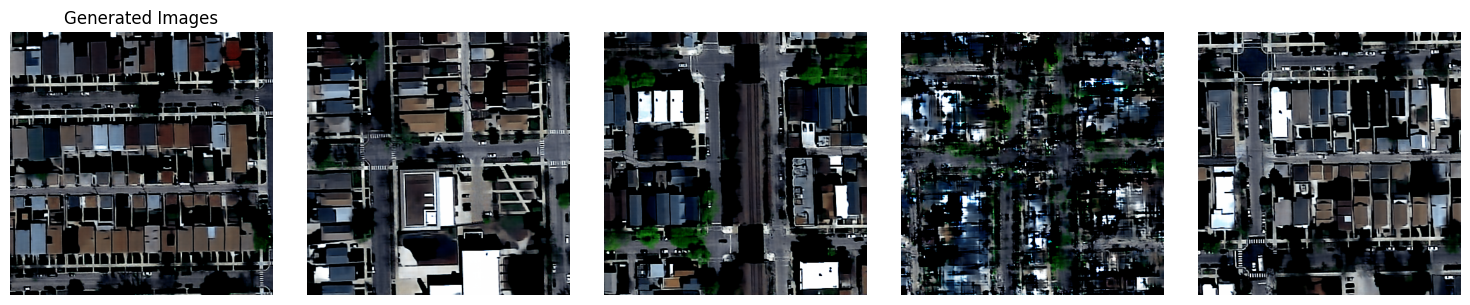

In [23]:
def visualize_generated_samples(generator, dataset, num_samples=5, figsize=(15, 3)):
    """
    Visualize only the generated images from the GAN
    
    """
    generator.eval()  # Set generator to evaluation mode
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)
    
    with torch.no_grad():
        for i in range(num_samples):
            idx = np.random.randint(len(dataset))
            _, mask = dataset[idx]
            
            # Ensure mask has correct dimensions
            if mask.dim() == 3:
                mask = mask.unsqueeze(0)
            else:
                mask = mask.unsqueeze(0).unsqueeze(0)
                
            # Generate image
            mask = mask.to(device)
            generated_image = generator(mask)
            
            # Convert to numpy and adjust format
            gen_img = generated_image.cpu().squeeze(0).numpy()
            gen_img = np.transpose(gen_img, (1, 2, 0))
            # Denormalize
            gen_img = (gen_img * 0.5 + 0.5).clip(0, 1)
            
            # Display
            axes[i].imshow(gen_img)
            axes[i].axis('off')
            if i == 0:
                axes[i].set_title('Generated Images')
    
    plt.tight_layout()
    plt.show()

visualize_generated_samples(gan.generator, train_val_dataset)

## Save the generated images and masks

In [28]:
def save_generated_samples(images, masks, image_dir, mask_dir):
    """
    Save generated images and masks to specified directories
    """
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(mask_dir, exist_ok=True)
    
    # Denormalize images
    denorm = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    
    for idx, (image, mask) in enumerate(zip(images, masks)):
        # Denormalize and convert image to PIL
        image = denorm(image)
        image = torch.clamp(image, 0, 1)
        image_pil = transforms.ToPILImage()(image)
        
        # Convert mask to PIL
        mask_pil = transforms.ToPILImage()(mask.squeeze())
        
        # Save files
        image_path = os.path.join(image_dir, f'generated_image_{idx:04d}.png')
        mask_path = os.path.join(mask_dir, f'generated_image_{idx:04d}.png')
        
        image_pil.save(image_path)
        mask_pil.save(mask_path)
    
    print(f"Saved {len(images)} generated images and masks")

image_dir = r"C:\\Users\\MSII\\Desktop\\sanad_JU\\Materials\\Deep Learning\\Project\\training\\images_generated"
mask_dir = r"C:\\Users\\MSII\\Desktop\\sanad_JU\\Materials\\Deep Learning\\Project\\training\\groundtruth_generated"

save_generated_samples(new_images, new_masks, image_dir, mask_dir)

Saved 1003 generated images and masks


## Load the augmented dataset for use

In [11]:
class LoadAugmentedDataset(Dataset):
    def __init__(self, original_dataset, generated_image_dir, generated_mask_dir, transform=None):
        self.original_dataset = original_dataset
        self.transform = transform
        
        # Get list of generated images
        self.generated_images = sorted(os.listdir(generated_image_dir))
        self.generated_image_dir = generated_image_dir
        self.generated_mask_dir = generated_mask_dir

    def __len__(self):
        return len(self.original_dataset) + len(self.generated_images)

    def __getitem__(self, idx):
        if idx < len(self.original_dataset):
            return self.original_dataset[idx]
        else:
            # Load generated image and mask
            idx = idx - len(self.original_dataset)
            image_name = self.generated_images[idx]
            
            image_path = os.path.join(self.generated_image_dir, image_name)
            mask_path = os.path.join(self.generated_mask_dir, image_name)
            
            image = Image.open(image_path).convert('RGB')
            mask = Image.open(mask_path).convert('L')
            
            if self.transform:
                image = self.transform(image)
            
            mask = transforms.ToTensor()(mask)
            mask = (mask > 0.5).float()
            
            return image, mask

## Create the dataloaders after generating the new images

In [12]:
# Create the augmented dataset with both original and generated data
augmented_dataset = LoadAugmentedDataset(
    original_dataset=train_val_dataset,  
    generated_image_dir=r"C:\Users\MSII\Desktop\sanad_JU\Materials\Deep Learning\Project\training\images_generated",
    generated_mask_dir=r"C:\Users\MSII\Desktop\sanad_JU\Materials\Deep Learning\Project\training\groundtruth_generated",
    transform=transform
)

# Split the augmented dataset into train and validation
train_size = int(0.75 * len(augmented_dataset))
val_size = len(augmented_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(augmented_dataset, [train_size, val_size])

# Create new dataloaders with the augmented dataset (test_loader created at the beginning above)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [13]:
print(train_size)
print(val_size)

827
276


## Loading Unet model, and training on the dataset

In [14]:
# Initialize pre-trained UNet model
model = Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                 
    classes=1,                      
).to(device)

In [15]:
def train_model_and_f1_score(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    best_val_f1 = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_f1': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        batch_count = 0
        
        for batch_idx, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)
            
            # Ensure masks have correct shape
            if masks.dim() == 3:
                masks = masks.unsqueeze(1)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            batch_count += 1
            
        avg_train_loss = train_loss / batch_count
            
        # Validation phase
        model.eval()
        val_f1 = 0
        val_loss = 0
        batch_count = 0
        all_preds = []
        all_masks = []
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                
                # Ensure masks have correct shape
                if masks.dim() == 3:
                    masks = masks.unsqueeze(1)
                
                outputs = model(images)
                val_loss += criterion(outputs, masks).item()
                
                pred = (torch.sigmoid(outputs) > 0.5).float()
                
                # Collect predictions and masks for F1 calculation
                all_preds.extend(pred.cpu().numpy().flatten())
                all_masks.extend(masks.cpu().numpy().flatten())
                
                batch_count += 1
        
        # Calculate metrics
        avg_val_loss = val_loss / batch_count
        val_f1 = f1_score(all_masks, all_preds)
        
        # Store history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_f1'].append(val_f1)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val F1: {val_f1:.4f}')
        
        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_f1': val_f1,
            }, 'C:\\Users\\MSII\\Desktop\\sanad_JU\\Materials\\Deep Learning\\Project\\best_model.pth')
            
    return best_val_f1, history

In [13]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the model
num_epochs = 10
val_f1, history = train_model_and_f1_score(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch [1/10] Train Loss: 0.4158, Val Loss: 0.3393, Val F1: 0.7642
Epoch [2/10] Train Loss: 0.2353, Val Loss: 0.1945, Val F1: 0.8992
Epoch [3/10] Train Loss: 0.1485, Val Loss: 0.1352, Val F1: 0.9295
Epoch [4/10] Train Loss: 0.1120, Val Loss: 0.1011, Val F1: 0.9495
Epoch [5/10] Train Loss: 0.0911, Val Loss: 0.0851, Val F1: 0.9562
Epoch [6/10] Train Loss: 0.0770, Val Loss: 0.0738, Val F1: 0.9637
Epoch [7/10] Train Loss: 0.0662, Val Loss: 0.0621, Val F1: 0.9734
Epoch [8/10] Train Loss: 0.0569, Val Loss: 0.0555, Val F1: 0.9757
Epoch [9/10] Train Loss: 0.0515, Val Loss: 0.0501, Val F1: 0.9773
Epoch [10/10] Train Loss: 0.0459, Val Loss: 0.0455, Val F1: 0.9796


## Testing and evaluating F1-score on the augmented dataset

In [16]:
def test_model_f1_scores(model, test_loader, output_dir='C:\\Users\\MSII\\Desktop\\sanad_JU\\Materials\\Deep Learning\\Project\\Predictions'):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    test_f1_scores = []
    
    with torch.no_grad():
        for images, image_names in test_loader:
            images = images.to(device)
            
            # Generate predictions
            outputs = model(images)
            predictions = (torch.sigmoid(outputs) > 0.5).float()
            
            # Calculate F1 score
            batch_f1 = f1_score(predictions.cpu().numpy().flatten(), 
                              outputs.cpu().numpy().flatten() > 0.5)
            test_f1_scores.append(batch_f1)
            
            # Save predictions
            for pred, name in zip(predictions, image_names):
                # Convert prediction to image
                pred_img = (pred.cpu().numpy()[0] * 255).astype(np.uint8)
                pred_img = Image.fromarray(pred_img)
                pred_img = pred_img.resize((400, 400))
                
                # Create directory and save
                test_num = name.split(os.sep)[0]
                os.makedirs(os.path.join(output_dir, test_num), exist_ok=True)
                save_path = os.path.join(output_dir, test_num, 'prediction.png')
                pred_img.save(save_path)
    
    print(f"Completed predictions for {len(test_loader.dataset)} test images")
    return test_f1_scores

In [16]:
checkpoint = torch.load('C:\\Users\\MSII\\Desktop\\sanad_JU\\Materials\\Deep Learning\\Project\\best_model.pth')

# Extract just the model state dict
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [23]:
f1_scores = test_model_f1_scores(model, test_loader)

Completed predictions for 50 test images


In [24]:
print(f'Min F1 Score: {min(f1_scores):.4f}')
print(f'Max F1 Score: {max(f1_scores):.4f}')

Min F1 Score: 0.9565
Max F1 Score: 0.9823
